# GAMC Implementation

In this notebook, we try to implement GAMC (Yin et al. 2023) in PyTorch Geometric.

## Installation and Imports

In [1]:
!pip install torch_geometric

In [2]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential
from torch.nn import BatchNorm1d as BatchNorm

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, GINConv, global_add_pool, global_max_pool, global_mean_pool
from torch_geometric.transforms import ToUndirected
from torch_geometric.nn.models.autoencoder import InnerProductDecoder

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

This cell is for mounting in Google Colab. If running locally, skip this cell and move on to the next to define the `path` variable.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive/CS365/data/UPFD'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Uncomment the following line and run this cell if the previous cell was not run
# path = '.'

## Loading Dataset

Here we just load the PolitiFact dataset.

In [13]:
pf_train = UPFD(path, 'politifact', 'bert', 'train', ToUndirected())
pf_val = UPFD(path, 'politifact', 'bert', 'val', ToUndirected())
pf_test = UPFD(path, 'politifact', 'bert', 'test', ToUndirected())


In [14]:
print("==== POLITIFACT ====")
print("Train:", pf_train)
print("Val:", pf_val)
print("Test:", pf_test)


==== POLITIFACT ====
Train: UPFD(62, name=politifact, feature=bert)
Val: UPFD(31, name=politifact, feature=bert)
Test: UPFD(221, name=politifact, feature=bert)


## Implementation

### Graph Isomorphism Network (GIN) Without Final ReLU

In [15]:
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        for i in range(num_layers):
            mlp = Sequential(
                Linear(in_channels, 2 * hidden_channels),
                BatchNorm(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            conv = GINConv(mlp, train_eps=True)

            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(hidden_channels))

            in_channels = hidden_channels

    def forward(self, x, edge_index):
        layer = 0
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = F.relu(batch_norm(conv(x, edge_index))) if layer == 0 else batch_norm(conv(x, edge_index))
            layer += 1
        return x

### Helper Functions

Here we implement the GAMC loss function (joint_loss). The loss function is made up of reconstruction loss (`rec_loss`) and contrastive loss (`con_loss`). The reconstruction loss is calculated by taking the difference between the reconstructed and original node embedding matrices, and calculating the mean of each row. The final `rec_loss` component is the average of the mean distances of both maskings.
<br/>

We mask 50% of the nodes and drop 20% of the edges as specified in GAMC.

In [16]:
def joint_loss(x1, x2, r1, r2):
    diff1 = x1 - r2
    diff2 = x2 - r2
    rec1 = (diff1 ** 2).sum(dim=1).mean()
    rec2 = (diff2 ** 2).sum(dim=1).mean()
    rec_loss = (rec1 + rec2) / 2

    con_loss = F.cosine_similarity(r1, r2, dim=1).mean()
    return rec_loss - 0.1 * con_loss

def mask_nodes(x, mask_token, rate=0.5):
    mask = torch.rand(x.size(0)) < rate
    masked = x.clone()
    masked[mask] = mask_token
    return masked, mask

def remask_nodes(h, mask_idx, remask_token):
    remasked = h.clone()
    remasked[mask_idx] = remask_token
    return remasked

def edge_drop(edge_idx, rate=0.2):
    idxs = torch.zeros(edge_idx.shape[1])
    idxs[int(rate*edge_idx.shape[1]):] = 1
    idxs = idxs[torch.randperm(idxs.shape[0])]
    dropped = edge_idx.clone()
    return dropped[:,idxs.bool()]

In [17]:
def eval_GAMC(model, decoder, train_dataset, val_dataset, test_dataset, epochs=80, batch_size=1):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=model.to(device)
    decoder = decoder.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = joint_loss

    # Masking tokens were unspecified in the original
    # paper so we use random noise vectors.
    mask_token = torch.rand(768)
    remask_token = torch.rand(512)

    def train():
        model.train()

        total_loss = 0
        for data in train_loader:

            # random node masking
            x1, mask1 = mask_nodes(data.x, mask_token)
            x2, mask2 = mask_nodes(data.x, mask_token)

            # random edge dropping
            e1 = edge_drop(data.edge_index)
            e2 = edge_drop(data.edge_index)

            x1, x2 = x1.to(device), x2.to(device)
            optimizer.zero_grad()

            # encoding
            h1 = model(x1, e1)
            h2 = model(x2, e2)

            # remask step
            h1 = remask_nodes(h1, mask1, remask_token)
            h2 = remask_nodes(h2, mask2, remask_token)

            # decoding
            r1 = decoder(h1, e1)
            r2 = decoder(h2, e2)

            loss = criterion(x1, x2, r1, r2)
            loss.backward()
            optimizer.step()

            total_loss += float(loss) * data.num_graphs

        return total_loss / len(train_loader.dataset)

    train_losses = np.zeros((epochs))

    for epoch in range(epochs):
        loss = train()
        train_losses[epoch] = loss
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

    fig, ax = plt.subplots()
    ax.plot(train_losses,'r-',label='train')
    ax.set_xlim(0,epochs)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
    ax.legend()
    plt.show()

    return model, decoder, train_losses

## Evaluations

We evaluate each encoder-decoder pair with different aggregation methods to generate the inputs to the SVM: averaging, maxpooling, and averaging without decoding.

### Non-ReLU GIN Encoder to Non-ReLU GIN Decoder

Epoch: 00, Loss: 1179.5374
Epoch: 01, Loss: 1178.0310
Epoch: 02, Loss: 1177.1782
Epoch: 03, Loss: 1178.1477
Epoch: 04, Loss: 1175.2198
Epoch: 05, Loss: 1176.4965
Epoch: 06, Loss: 1175.1510
Epoch: 07, Loss: 1174.2570
Epoch: 08, Loss: 1174.1554
Epoch: 09, Loss: 1174.5192
Epoch: 10, Loss: 1172.3754
Epoch: 11, Loss: 1173.2596
Epoch: 12, Loss: 1175.5719
Epoch: 13, Loss: 1172.4720
Epoch: 14, Loss: 1172.3116
Epoch: 15, Loss: 1173.4807
Epoch: 16, Loss: 1173.3253
Epoch: 17, Loss: 1171.1071
Epoch: 18, Loss: 1171.1405
Epoch: 19, Loss: 1172.8033
Epoch: 20, Loss: 1169.8928
Epoch: 21, Loss: 1174.1346
Epoch: 22, Loss: 1173.0038
Epoch: 23, Loss: 1173.4451
Epoch: 24, Loss: 1169.9880
Epoch: 25, Loss: 1171.7094
Epoch: 26, Loss: 1171.2471
Epoch: 27, Loss: 1173.1653
Epoch: 28, Loss: 1174.2781
Epoch: 29, Loss: 1171.9698
Epoch: 30, Loss: 1170.5519
Epoch: 31, Loss: 1170.6692
Epoch: 32, Loss: 1173.7150
Epoch: 33, Loss: 1171.3171
Epoch: 34, Loss: 1169.7484
Epoch: 35, Loss: 1171.3815
Epoch: 36, Loss: 1170.7125
E

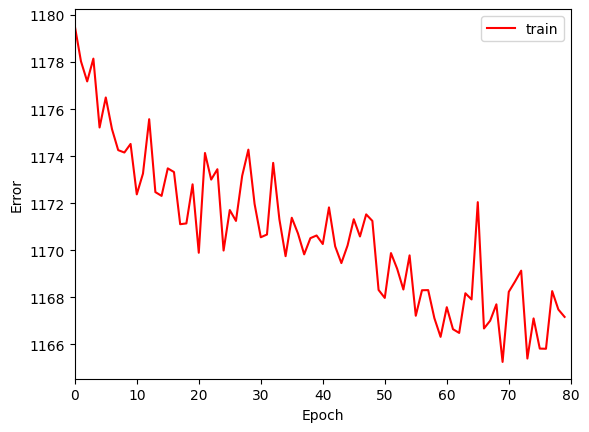

In [18]:
pf_encoder, pf_decoder, pf_train_losses = eval_GAMC(GIN(768, 512, 2), GIN(512, 768, 2), pf_train, pf_val, pf_test, batch_size=128, epochs=80)

In [19]:
from sklearn.svm import LinearSVC, SVC

@torch.no_grad()
def eval_meanpool_classifier(encoder, decoder, train_graphs, test_graphs):
    X_train = np.zeros((len(train_graphs), 768))
    y_train = np.zeros((len(train_graphs)))

    X_test = np.zeros((len(test_graphs), 768))
    y_test = np.zeros((len(test_graphs)))

    with torch.no_grad():
        for i in range(len(train_graphs)):
            h = encoder(train_graphs[i].x, train_graphs[i].edge_index)
            r = decoder(h, train_graphs[i].edge_index)
            X_train[i] = r.mean(dim=0)
            y_train[i] = train_graphs[i].y.item()

        for i in range(len(test_graphs)):
            h = encoder(test_graphs[i].x, test_graphs[i].edge_index)
            r = decoder(h, test_graphs[i].edge_index)
            X_test[i] = r.mean(dim=0)
            y_test[i] = test_graphs[i].y.item()


    svm = SVC(gamma='auto', random_state=0, tol=1e-5, max_iter=10000)
    svm.fit(X_train, y_train)

    return svm.score(X_test, y_test)


In [20]:
eval_meanpool_classifier(pf_encoder, pf_decoder, pf_train, pf_test)

0.48868778280542985

In [21]:
@torch.no_grad()
def eval_maxpool_classifier(encoder, decoder, train_graphs, test_graphs):
    X_train = np.zeros((len(train_graphs), 768))
    y_train = np.zeros((len(train_graphs)))

    X_test = np.zeros((len(test_graphs), 768))
    y_test = np.zeros((len(test_graphs)))

    with torch.no_grad():
        for i in range(len(train_graphs)):
            h = encoder(train_graphs[i].x, train_graphs[i].edge_index)
            r = decoder(h, train_graphs[i].edge_index)
            X_train[i] = r.max(dim=0)[0]
            y_train[i] = train_graphs[i].y.item()

        for i in range(len(test_graphs)):
            h = encoder(test_graphs[i].x, test_graphs[i].edge_index)
            r = decoder(h, test_graphs[i].edge_index)
            X_test[i] = r.max(dim=0)[0]
            y_test[i] = test_graphs[i].y.item()


    svm = SVC(gamma='auto', random_state=0, tol=1e-5, max_iter=10000)
    svm.fit(X_train, y_train)

    return svm.score(X_test, y_test)


In [22]:
eval_maxpool_classifier(pf_encoder, pf_decoder, pf_train, pf_test)

0.49321266968325794

In [23]:
@torch.no_grad()
def eval_encode_only_classifier(encoder, decoder, train_graphs, test_graphs):
    X_train = np.zeros((len(train_graphs), 512))
    y_train = np.zeros((len(train_graphs)))

    X_test = np.zeros((len(test_graphs), 512))
    y_test = np.zeros((len(test_graphs)))

    with torch.no_grad():
        for i in range(len(train_graphs)):
            h = encoder(train_graphs[i].x, train_graphs[i].edge_index)
            X_train[i] = h.mean(dim=0)
            y_train[i] = train_graphs[i].y.item()

        for i in range(len(test_graphs)):
            h = encoder(test_graphs[i].x, test_graphs[i].edge_index)
            X_test[i] = h.mean(dim=0)
            y_test[i] = test_graphs[i].y.item()


    svm = SVC(gamma='auto', random_state=0, tol=1e-5, max_iter=10000)
    svm.fit(X_train, y_train)

    return svm.score(X_test, y_test)


In [24]:
eval_encode_only_classifier(pf_encoder, pf_decoder, pf_train, pf_test)

0.48868778280542985

### Non-ReLU GIN Encoder to GCN Decoder

In [25]:
class DecoderGCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderGCN, self).__init__()
        torch.manual_seed(12345)

        self.conv1 = GCNConv(in_channels, in_channels)
        self.conv2 = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        h1 = self.conv1(x, edge_index).relu()
        h2 = self.conv2(h1, edge_index)
        return h2

Epoch: 00, Loss: 503.2075
Epoch: 01, Loss: 483.5126
Epoch: 02, Loss: 452.1316
Epoch: 03, Loss: 443.5667
Epoch: 04, Loss: 434.7780
Epoch: 05, Loss: 432.6263
Epoch: 06, Loss: 428.7590
Epoch: 07, Loss: 425.4844
Epoch: 08, Loss: 424.1353
Epoch: 09, Loss: 420.0869
Epoch: 10, Loss: 419.4393
Epoch: 11, Loss: 421.0372
Epoch: 12, Loss: 417.1337
Epoch: 13, Loss: 417.4709
Epoch: 14, Loss: 414.0855
Epoch: 15, Loss: 411.4726
Epoch: 16, Loss: 413.4453
Epoch: 17, Loss: 412.7687
Epoch: 18, Loss: 412.8427
Epoch: 19, Loss: 408.7769
Epoch: 20, Loss: 405.7718
Epoch: 21, Loss: 406.8835
Epoch: 22, Loss: 405.4496
Epoch: 23, Loss: 405.4642
Epoch: 24, Loss: 403.6413
Epoch: 25, Loss: 404.9449
Epoch: 26, Loss: 403.0206
Epoch: 27, Loss: 403.7596
Epoch: 28, Loss: 402.0986
Epoch: 29, Loss: 402.8485
Epoch: 30, Loss: 400.9514
Epoch: 31, Loss: 398.4551
Epoch: 32, Loss: 400.7698
Epoch: 33, Loss: 399.6178
Epoch: 34, Loss: 398.9012
Epoch: 35, Loss: 398.4403
Epoch: 36, Loss: 396.8593
Epoch: 37, Loss: 396.0431
Epoch: 38, L

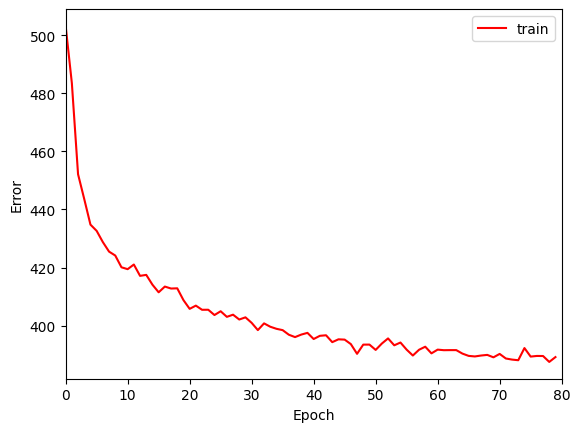

In [26]:
pf_encoder_gcn, pf_decoder_gcn, pf_train_losses_gcn = eval_GAMC(GIN(768, 512, 2), DecoderGCN(512, 768), pf_train, pf_val, pf_test, batch_size=128, epochs=80)

In [27]:
eval_meanpool_classifier(pf_encoder_gcn, pf_decoder_gcn, pf_train, pf_test)

0.48868778280542985

In [28]:
eval_maxpool_classifier(pf_encoder_gcn, pf_decoder_gcn, pf_train, pf_test)

0.48868778280542985

In [29]:
eval_encode_only_classifier(pf_encoder_gcn, pf_decoder_gcn, pf_train, pf_test)

0.48868778280542985

### ReLU GIN Encoder to GCN Decoder

In [30]:
class GIN_ReLU(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        for i in range(num_layers):
            mlp = Sequential(
                Linear(in_channels, 2 * hidden_channels),
                BatchNorm(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            conv = GINConv(mlp, train_eps=True)

            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(hidden_channels))

            in_channels = hidden_channels

    def forward(self, x, edge_index):
        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = F.relu(batch_norm(conv(x, edge_index)))
        return x

Epoch: 00, Loss: 492.6678
Epoch: 01, Loss: 475.5983
Epoch: 02, Loss: 456.8559
Epoch: 03, Loss: 451.3951
Epoch: 04, Loss: 442.8875
Epoch: 05, Loss: 439.7136
Epoch: 06, Loss: 435.3586
Epoch: 07, Loss: 431.9589
Epoch: 08, Loss: 432.2603
Epoch: 09, Loss: 429.5836
Epoch: 10, Loss: 428.6216
Epoch: 11, Loss: 431.3447
Epoch: 12, Loss: 427.8659
Epoch: 13, Loss: 428.2721
Epoch: 14, Loss: 426.4948
Epoch: 15, Loss: 424.0569
Epoch: 16, Loss: 426.3570
Epoch: 17, Loss: 427.1084
Epoch: 18, Loss: 427.8476
Epoch: 19, Loss: 424.5129
Epoch: 20, Loss: 421.6665
Epoch: 21, Loss: 423.6052
Epoch: 22, Loss: 422.3835
Epoch: 23, Loss: 423.3270
Epoch: 24, Loss: 422.1501
Epoch: 25, Loss: 424.6141
Epoch: 26, Loss: 422.6707
Epoch: 27, Loss: 423.4479
Epoch: 28, Loss: 422.5385
Epoch: 29, Loss: 424.1054
Epoch: 30, Loss: 421.8351
Epoch: 31, Loss: 419.9038
Epoch: 32, Loss: 421.6698
Epoch: 33, Loss: 420.9079
Epoch: 34, Loss: 421.0750
Epoch: 35, Loss: 420.6665
Epoch: 36, Loss: 419.6300
Epoch: 37, Loss: 419.0158
Epoch: 38, L

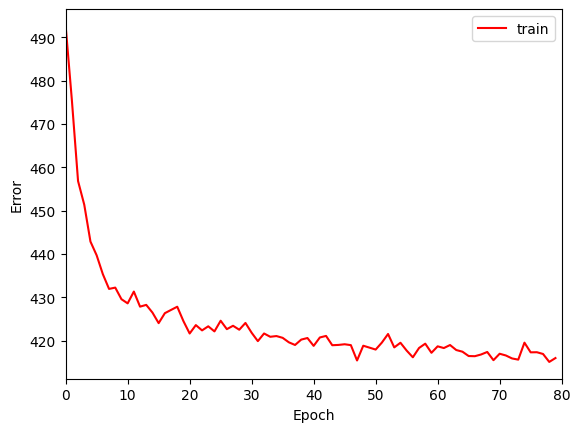

In [31]:
pf_encoder_og, pf_decoder_og, pf_train_losses_og = eval_GAMC(GIN_ReLU(768, 512, 2), DecoderGCN(512, 768), pf_train, pf_val, pf_test, batch_size=128, epochs=80)

In [32]:
eval_meanpool_classifier(pf_encoder_og, pf_decoder_og, pf_train, pf_test)

0.48868778280542985

In [33]:
eval_maxpool_classifier(pf_encoder_og, pf_decoder_og, pf_train, pf_test)

0.48868778280542985

In [34]:
eval_encode_only_classifier(pf_encoder_og, pf_decoder_og, pf_train, pf_test)

0.48868778280542985